In [11]:

import sys
import glob
import os 
import numpy as np
import matplotlib.pyplot as plt
# path of data 
def set_path():
    if sys.platform == 'darwin':
        print("Current system is macOS")
        main_fold_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction'
    elif sys.platform == 'linux':
        print("Current system is Ubuntu")
        main_fold_path = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning'
        
    else:
        print("Current system is neither macOS nor Ubuntu")
    sys.path.append(main_fold_path)
    os.chdir(main_fold_path)
set_path()

from classifiers.layer.preprocess_layer import *


# Custom loss function to maximize the difference between HC and MDD
def custom_loss(y_true, y_pred):
    labels = y_true[:, 0]
    data = y_pred
    
    # Create masks for HC and MDD
    mask_HC = tf.equal(labels, 0)
    mask_MDD = tf.equal(labels, 1)
    
    # Calculate mean values for HC and MDD
    HbO_HC = tf.reduce_mean(tf.boolean_mask(data[..., 0], mask_HC), axis=0)
    HbR_HC = tf.reduce_mean(tf.boolean_mask(data[..., 1], mask_HC), axis=0)
    
    HbO_MDD = tf.reduce_mean(tf.boolean_mask(data[..., 0], mask_MDD), axis=0)
    HbR_MDD = tf.reduce_mean(tf.boolean_mask(data[..., 1], mask_MDD), axis=0)
    
    # Calculate the absolute differences
    diff_HbO = tf.abs(HbO_HC - HbO_MDD)
    diff_HbR = tf.abs(HbR_HC - HbR_MDD)
    
    # Log loss to improve numerical stability
    log_diff_HbO = tf.math.log(1 + diff_HbO)
    log_diff_HbR = tf.math.log(1 + diff_HbR)
    
    # Combine the differences
    loss = -(log_diff_HbO + log_diff_HbR)
    
    return loss


input_data = np.load('allData/diagnosis514_light/light_data.npy')
labels = np.load('allData/diagnosis514_light/label.npy')
shape = input_data.shape[1:] 



from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, Lambda

# Define the model inputs
inputs = Input(shape=shape)

# Prepare labels for custom loss
y_true = np.zeros((514, 1))
y_true[:, 0] = labels  # Adding labels to y_true for custom loss function

# Apply the MBLL Layer
outputs = MLP_Preprocess_Layer()(inputs)

# Create the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=1e-5), loss=custom_loss)

# Display model summary
model.summary()

# Train 
# history = model.fit(input_data, y_true, epochs=1500, batch_size=16, validation_split=0.2)

Current system is Ubuntu
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 52, 3402)]        0         
                                                                 
 mlp__preprocess__layer_2 (  (None, 52, 1701, 2)       20704     
 MLP_Preprocess_Layer)                                           
                                                                 
Total params: 20704 (80.88 KB)
Trainable params: 20704 (80.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
results = model.predict(input_data)
# model.get_layer(index=1).epsilon_HbO_695, model.get_layer(index=1).epsilon_HbR_695, model.get_layer(index=1).epsilon_HbO_830, model.get_layer(index=1).epsilon_HbR_830, model.get_layer(index=1).dpf_695, model.get_layer(index=1).dpf_830

17/17 [==============================] - 1s 39ms/step


In [4]:
def calcualte_convert_dpf(x):
    return 1.5 + tf.sigmoid(x)*2.0
results = model.predict(input_data)
model.get_layer(index=1).epsilon_HbO_695, model.get_layer(index=1).epsilon_HbR_695, model.get_layer(index=1).epsilon_HbO_830, model.get_layer(index=1).epsilon_HbR_830, calcualte_convert_dpf(model.get_layer(index=1).dpf_695_unconstrained), calcualte_convert_dpf(model.get_layer(index=1).dpf_830_unconstrained)



17/17 [==============================] - 0s 2ms/step


(<tf.Variable 'epsilon_HbO_695:0' shape=() dtype=float32, numpy=283.97708>,
 <tf.Variable 'epsilon_HbR_695:0' shape=() dtype=float32, numpy=1945.289>,
 <tf.Variable 'epsilon_HbO_830:0' shape=() dtype=float32, numpy=967.2273>,
 <tf.Variable 'epsilon_HbR_830:0' shape=() dtype=float32, numpy=694.8527>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.5>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.5000001>)

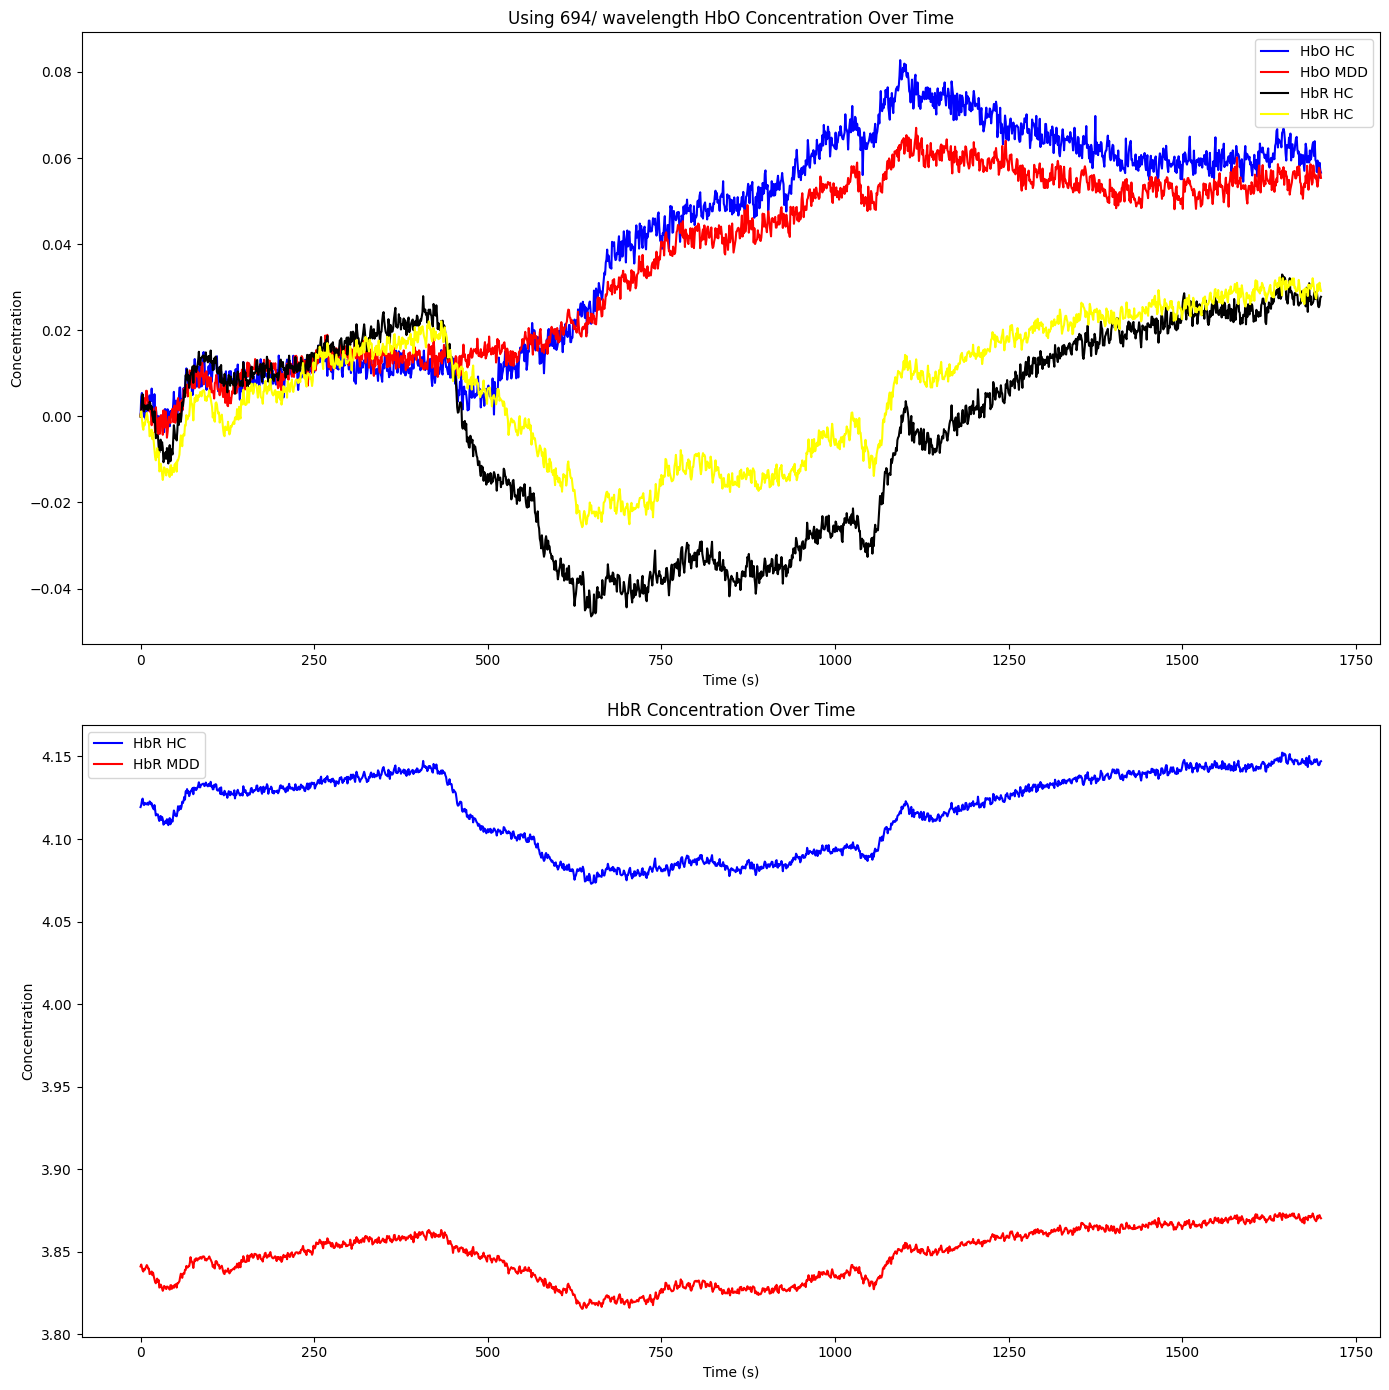

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# timesteps_half = input_data.shape[2] // 2
# I_695 = input_data[:, :, :timesteps_half]
# I_830 = input_data[:, :, timesteps_half:]
# results = np.concatenate((I_695[..., np.newaxis], I_830[..., np.newaxis]), axis=-1)


# Extract HbO and HbR results for HC and MDD
HbO_HC = results[labels == 0, ..., 0].mean(axis=(0, 1))
HbR_HC = results[labels == 0, ..., 1].mean(axis=(0, 1))

HbO_MDD = results[labels == 1, ..., 0].mean(axis=(0, 1))
HbR_MDD = results[labels == 1, ..., 1].mean(axis=(0, 1))

# Plot the results
plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
plt.plot(HbO_HC - HbO_HC[0], label='HbO HC', color='blue')
plt.plot(HbO_MDD - HbO_MDD[0], label='HbO MDD', color='red')
plt.plot(HbR_HC - HbR_HC[0], label='HbR HC', color='black')
plt.plot(HbR_MDD - HbR_MDD[0], label='HbR HC', color='yellow')

plt.title('Using 694/ wavelength HbO Concentration Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(HbR_HC, label='HbR HC', color='blue')
plt.plot(HbR_MDD, label='HbR MDD', color='red')
plt.title('HbR Concentration Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.legend()

plt.tight_layout()
plt.show()


<tf.Variable 'epsilon_HbO_695:0' shape=() dtype=float32, numpy=298.00983>

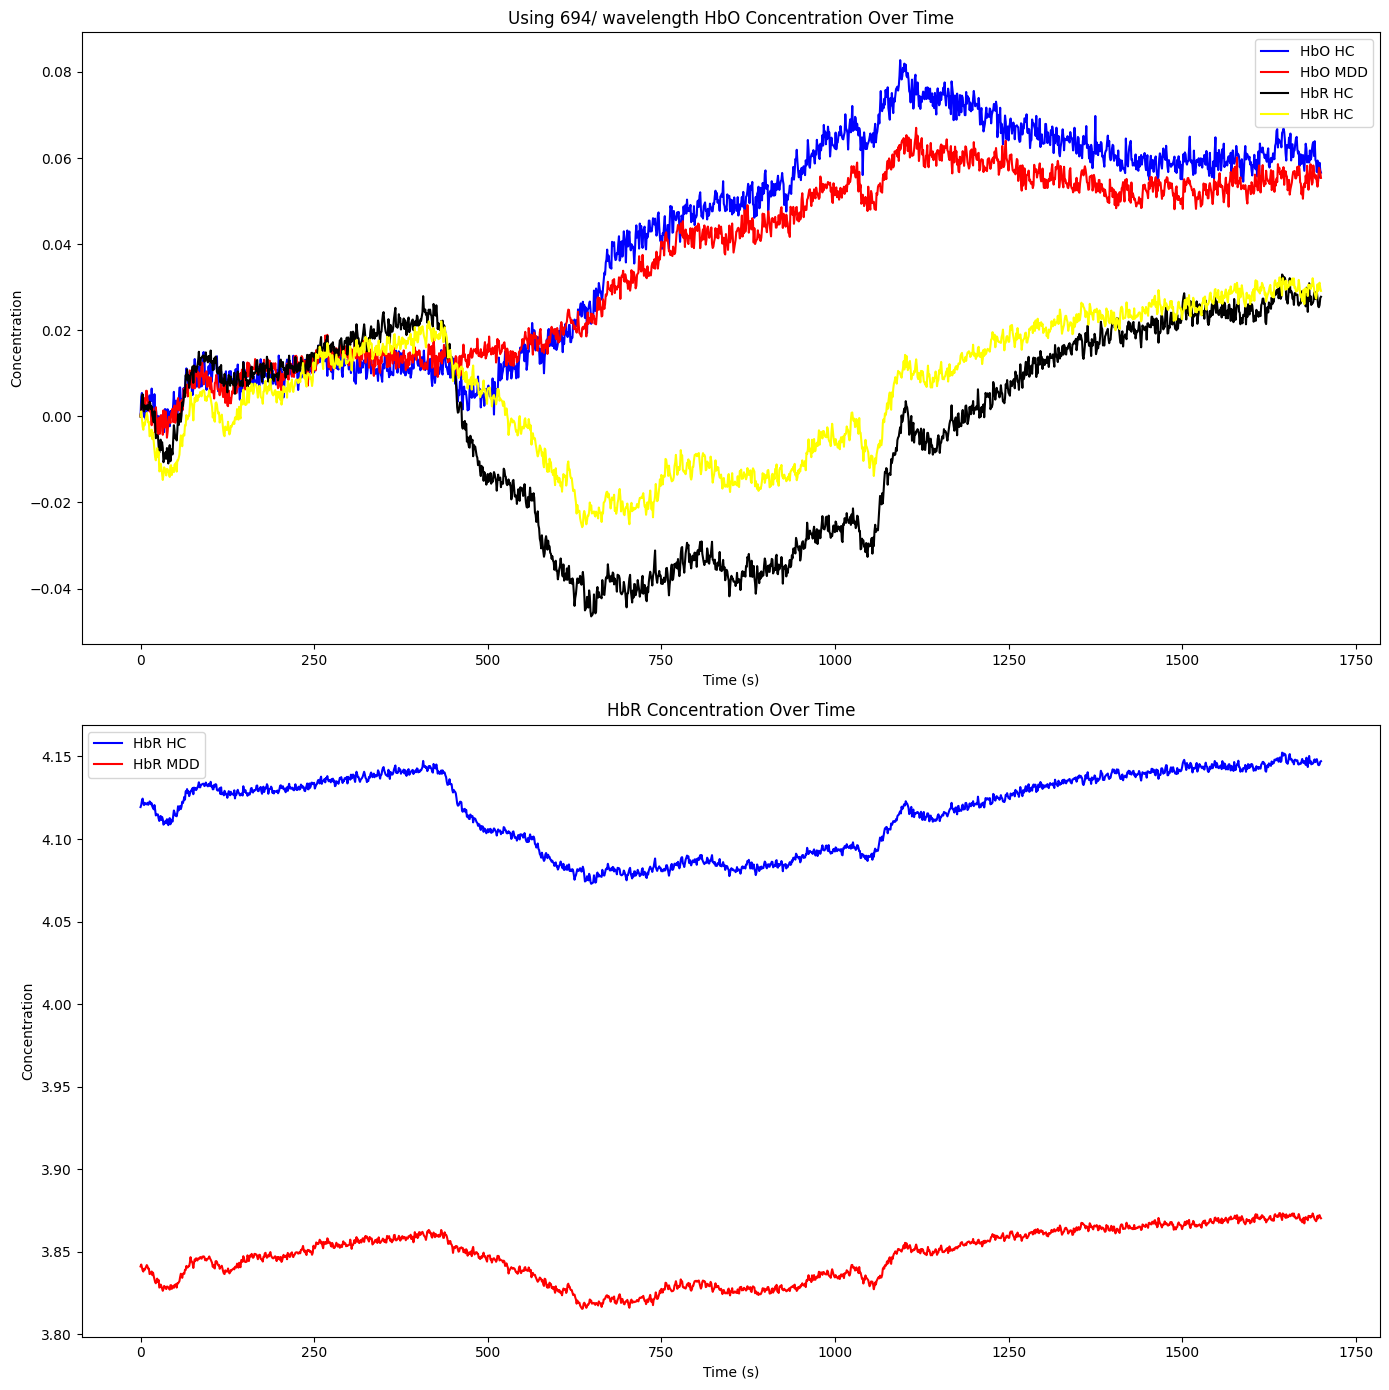

In [14]:
import matplotlib.pyplot as plt
import numpy as np

timesteps_half = input_data.shape[2] // 2
I_695 = input_data[:, :, :timesteps_half]
I_830 = input_data[:, :, timesteps_half:]
results = np.concatenate((I_695[..., np.newaxis], I_830[..., np.newaxis]), axis=-1)


# Extract HbO and HbR results for HC and MDD
HbO_HC = results[labels == 0, ..., 0].mean(axis=(0, 1))
HbR_HC = results[labels == 0, ..., 1].mean(axis=(0, 1))

HbO_MDD = results[labels == 1, ..., 0].mean(axis=(0, 1))
HbR_MDD = results[labels == 1, ..., 1].mean(axis=(0, 1))

# Plot the results
plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
plt.plot(HbO_HC - HbO_HC[0], label='HbO HC', color='blue')
plt.plot(HbO_MDD - HbO_MDD[0], label='HbO MDD', color='red')
plt.plot(HbR_HC - HbR_HC[0], label='HbR HC', color='black')
plt.plot(HbR_MDD - HbR_MDD[0], label='HbR HC', color='yellow')

plt.title('Using 694/ wavelength HbO Concentration Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(HbR_HC, label='HbR HC', color='blue')
plt.plot(HbR_MDD, label='HbR MDD', color='red')
plt.title('HbR Concentration Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
results.shape

data_3d = np.concatenate((results[..., 0], results[..., 1]), axis=-1)

np.save('allData/diagnosis514_light/light_data_mlp_preprocessed.npy', data_3d)

: 